In [167]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [168]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [169]:
len(words)

32033

In [170]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [171]:
#dataset

block_size = 3
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] 

X = torch.tensor(X)
Y = torch.tensor(Y)


In [172]:
X.shape, X.dtype, Y.shape, Y.dtype 

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [241]:
# build dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [173]:
C = torch.randn((27,2))

In [174]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [175]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [176]:
# torch.cat(torch.unbind(emb, 1), 1).shape
# emb.view(32, 6).shape

In [177]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [178]:
h

tensor([[-7.5036e-01, -9.2753e-01,  6.7541e-01,  ..., -9.8342e-01,
         -5.1943e-01,  2.2698e-01],
        [-8.1477e-01, -9.0830e-01,  6.2260e-01,  ..., -9.8637e-01,
         -1.6048e-01,  2.5868e-01],
        [-6.0180e-01, -8.9074e-01,  7.9044e-01,  ..., -9.7015e-01,
         -2.7195e-04,  2.0012e-01],
        ...,
        [ 8.7435e-01, -9.9976e-01, -8.2526e-02,  ..., -9.2713e-01,
          9.8843e-01,  2.6421e-01],
        [ 9.6954e-01, -8.0189e-01,  4.9568e-01,  ..., -9.9997e-01,
          9.7854e-01,  9.9877e-01],
        [ 9.7541e-01, -9.9801e-01,  9.9942e-01,  ..., -9.9998e-01,
          1.0000e+00,  8.4272e-01]])

In [179]:
h.shape

torch.Size([228146, 100])

In [180]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [181]:
logits = h @ W2 + b2

In [182]:
logits.shape

torch.Size([228146, 27])

In [183]:
counts = logits.exp()

In [184]:
prob = counts/ counts.sum(1, keepdim=True)

In [185]:
prob.shape

torch.Size([228146, 27])

In [186]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

## Formatiing


In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [257]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [258]:
sum(p.nelement() for p in parameters)

10281

In [259]:
for p in parameters:
    p.requires_grad = True

In [251]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [260]:
lri = []
lossi = []
stepi = []
for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], size=(32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    loss = F.cross_entropy(logits, Ytr[ix])
    loss
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track sets
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

3.008521556854248


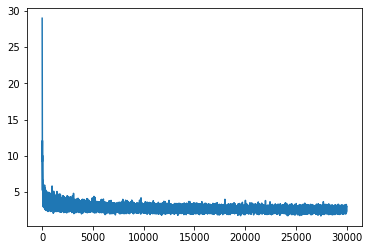

In [261]:
plt.plot(stepi, lossi)

In [256]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2922, grad_fn=<NllLossBackward0>)

In [255]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2916, grad_fn=<NllLossBackward0>)

In [ ]:
# train , dev, validation data split
# 80%, 10%, 10%